In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.signal import savgol_filter

NDWI

In [2]:
ndwi = pd.read_csv("C:/Users/antonkout/Documents/Work/antonkoutpersolnal/komotini/index/featurespace_object_NDWI.csv", header=0)

In [3]:
ndwi.columns.values[1:] = [1,6,16,26,31,36,66,71,86,91,96,111,116,121,136,141,146,151,156,161,166,171,176,181,186,191,
                          196,201,206,211,216,221,226,231,236,241,246,251,256,261,266,271,281,291,306,314,316,336,341,361]
obj_ids = ndwi.iloc[:,0]
del ndwi['id']
ndwi = ndwi.replace(-9999999, -999999)
ndwi = ndwi.replace(np.nan, -999999)
new_days = ["2018-01-10", "2018-01-20", "2018-01-30", "2018-02-10", "2018-02-20", "2018-02-28","2018-03-10", "2018-03-20", 
            "2018-03-30", "2018-04-10", "2018-04-20", "2018-04-30", "2018-05-10", "2018-05-20", "2018-05-30", "2018-06-10", 
            "2018-06-20", "2018-06-30", "2018-07-10", "2018-07-20", "2018-07-30", "2018-08-10", "2018-08-20", "2018-08-30", 
            "2018-09-10", "2018-09-20", "2018-09-30", "2018-10-10", "2018-10-20", "2018-10-30", "2018-11-10", "2018-11-20",
            "2018-11-30","2018-12-10","2018-12-20","2018-12-30"]
ndwi = ndwi.T
ndwi.index.name = 'doys' #Create decadal dates to have a fixed timestep
ndwi.reset_index(inplace=True)
nd = list()
for i in range(len(new_days)):
    nd.append(datetime.strptime(new_days[i], '%Y-%m-%d').timetuple().tm_yday)
ndwi=ndwi[1:ndwi.shape[0]]

In [4]:
ndwinn = ndwi.drop(['doys'], axis=1)
ndwinn.index = ndwi.doys
ndwinn = ndwinn.replace(-999999, np.nan)
ndwinn = ndwinn.replace(-9999999, np.nan)
l=np.zeros(shape=(ndwinn.shape[0],2))
for i in range(ndwinn.shape[0]):
    l[i,0] = np.nanstd(ndwinn.iloc[i,:])
    l[i,1] = np.nanmean(ndwinn.iloc[i,:])
l = pd.DataFrame(l)
l.columns = ['std_l','mean_l']

#Find 99.7 of the data that are within +- 3std
l['lower_limit'] = (l.mean_l-3*l.std_l)
l['upper_limit'] = (l.mean_l+3*l.std_l)
l = pd.DataFrame(l)
l.index = ndwinn.index
outliers = []
for i in range(ndwinn.shape[0]):
    for j in range(ndwinn.shape[1]):
        if((ndwinn.iloc[i,j]<l.iloc[i,2]) or (ndwinn.iloc[i,j]>l.iloc[i,3])):
            outliers.append(ndwinn.iloc[i,j])
            ndwinn.iloc[i,j] = np.nan
print('--- Number of total outliers found: %s ---'%len(outliers))
ndwinn.insert (0, 'doys', ndwinn.index)
ndwinn.index = range(0,ndwinn.shape[0])
ndwinn = ndwinn.replace(np.nan,-999999)
ndwi = ndwinn.copy()

--- Number of total outliers found: 15 ---


C:\Users\antonkout\anaconda3\envs\e-shape\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\antonkout\anaconda3\envs\e-shape\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


In [5]:
ndwi = ndwi.replace(np.nan,-999999)
#Weighted Average Interpolation, search +-5 days to find the reference days 
#from which the new dates will be created
l = np.zeros(ndwi.shape[0])
for i in range(ndwi.shape[0]):
    for j in range(len(nd)):
        x = ndwi.iloc[i,0]
        y = nd[j]
        if (abs(x-y) <= 5):
            l[i] = y
ndwi = pd.concat([pd.DataFrame(l),ndwi.reset_index(drop=True)], axis=1) #
ndwi.columns.values[0] = 'ref'
del new_days,nd
colnames = ndwi.columns.values
def interp_weight (df):
    dfn = np.zeros(shape=(df.shape[0],df.shape[1]))    
    #colnames = df.columns.values
    i = 0
    while (i <= (df.shape[0]-1)):
        if (i == (df.shape[0]-1)):
            dfn[i,:] = df[i,:] #When i becomes the last row then import the last row
            i=i+1
        elif (df[i,0] != df[i+1,0]):
            dfn[i,:] = df[i,:] #If value of ref at i is different at value of ref at i+1 then import the i line 
            i=i+1        
        else:
            if (df[i,0] == df[i,1]): #If value of ref at i is equal to value of doys at the same line i then import i line
                dfn[i,:] = df[i,:]
                i=i+2
            elif (df[i+1,0] == df[i+1,1]): #If value of ref at i+1 is equal to value of doys at the i+1 line import i+1 line 
                dfn[i,:] = df[i+1,:]
                i=i+2
            else:
                diff = df[i+1,1] - df[i,1]
                dist = abs(df[i,1] - df[i,0])
                w = (diff-dist)/diff
                df[i,:][df[i,:]==(-999999)] = df[i+1,:][df[i,:]==(-999999)]
                df[i+1,:][df[i+1,]==(-999999)] = df[i,:][df[i+1,:]==(-999999)]
                new_row = w*df[i,:] + (1-w)*df[i+1,] 
                dfn[i,:] = new_row
                i = i + 2    
    #dfn.columns = colnames
    return pd.DataFrame(dfn)
ndwi = np.array(ndwi)
ndwi = interp_weight(ndwi)
ndwi.columns = colnames
ndwi = ndwi.replace(-999999.0000000001, np.nan)
ndwi = ndwi.replace(-999999.0, np.nan)
ndwi = ndwi.drop(['doys'], axis=1)
del colnames
d = list()
for i in range(ndwi.shape[0]):
    if (ndwi.iloc[i,0]==0):
        d.append(i)      
ndwi = ndwi.drop(d, axis=0)  
del d
ndwi = ndwi.drop(ndwi.index[16])
ndwi.index = ndwi.ref
ndwi = ndwi.drop(['ref'], axis=1)
ndwin = ndwi.copy()

In [6]:
polynomial = np.zeros(shape=ndwin.shape)
obj_id = np.array(ndwin.columns)
#Apply Polynomial Interpolation second order, replace timeseries with less than 3 values with nan to remove them afterwards
time_with_less = []
for i in range(ndwin.shape[1]):
    if (len(ndwin.iloc[:,i].unique())>3):
        pd.DataFrame(polynomial).iloc[:,i] = pd.DataFrame(np.array(ndwin.iloc[:,i]).flatten()).interpolate(method ='polynomial', order=2).ffill().bfill()
    else:
        time_with_less.append(ndwin.columns[i])
        polynomial[:,i] = np.nan

In [7]:
print('Found %s timeseries with less than 3 values' %len(time_with_less))
polynomial = pd.DataFrame(polynomial)
polynomial.index = ndwin.index
###Apply again Outlier Detection with Normal Distribution
l = np.zeros(shape=(polynomial.shape[0],2))
for i in range(polynomial.shape[0]):
    l[i,0] = np.nanstd(polynomial.iloc[i,:])
    l[i,1] = np.nanmean(polynomial.iloc[i,:])
l = pd.DataFrame(l)
l.columns = ['std_l','mean_l']

#Find 99.7 of the data that are within +- 3std
l['lower_limit'] = (l.mean_l-3*l.std_l)
l['upper_limit'] = (l.mean_l+3*l.std_l)
l = pd.DataFrame(l)
l.index = polynomial.index
outliers = []
for i in range(polynomial.shape[0]):
    for j in range(polynomial.shape[1]):
        if((polynomial.iloc[i,j]<l.iloc[i,2]) or (polynomial.iloc[i,j]>l.iloc[i,3])):
            outliers.append(polynomial.iloc[i,j])
            polynomial.iloc[i,j] = np.nan 
print('--- Number of total outliers found: %s ---'%len(outliers))

Found 0 timeseries with less than 3 values
--- Number of total outliers found: 5 ---


In [8]:
new_doys = list(range(0,365))
old_doys = np.array(polynomial.index)
new_doys = np.array(new_doys)
ndwin = np.zeros(shape=(len(new_doys),polynomial.shape[1]))
ndwin[ndwin == 0] = 'nan'

for i in range(ndwin.shape[0]):
    if (i in old_doys):
        ndwin[i,:] = polynomial.loc[polynomial.index==i,:]
#ndwin[:,0] = range(0,365)
ndwin = pd.DataFrame(ndwin)
#ndwin.columns = obj_id
print('---Drop %s from %s timeseries with less than 3 values---' %(len(time_with_less) ,ndwin.shape[1]))

#ids = np.setdiff1d(np.union1d(obj_id, time_with_less), np.intersect1d(obj_id, time_with_less))
ndwin = ndwin.dropna(axis='columns', how='all')

linear = np.zeros(shape=ndwin.shape)

for i in range(ndwin.shape[1]):
    linear[:,i] = ndwin.iloc[:,i].interpolate(method ='linear', axis=0).ffill().bfill()

linear = pd.DataFrame(linear)
linear.columns = ndwin.columns
savitzky = np.zeros(shape=linear.shape)
for i in range(savitzky.shape[1]):
    savitzky[:,i] = savgol_filter(np.array(linear.iloc[0:,i]).reshape(linear.shape[0]),mode='nearest', 
                                  window_length = 51, polyorder = 4)
savitzky = pd.DataFrame(savitzky)
savitzky.index = range(0,savitzky.shape[0])

---Drop 0 from 45 timeseries with less than 3 values---


In [9]:
ndwi = savitzky.copy()

PSRI

In [10]:
psri = pd.read_csv("C:/Users/antonkout/Documents/Work/antonkoutpersolnal/komotini/index/featurespace_object_PSRI.csv", header=0)

In [11]:
psri.columns.values[1:] = [1,6,16,26,31,36,66,71,86,91,96,111,116,121,136,141,146,151,156,161,166,171,176,181,186,191,
                          196,201,206,211,216,221,226,231,236,241,246,251,256,261,266,271,281,291,306,314,316,336,341,361]
obj_id = psri.iloc[:,0]
del psri['id']
psri = psri.replace(-9999999, -999999)
psri = psri.replace(np.nan, -999999)
new_days = ["2018-01-10", "2018-01-20", "2018-01-30", "2018-02-10", "2018-02-20", "2018-02-28","2018-03-10", "2018-03-20", 
            "2018-03-30", "2018-04-10", "2018-04-20", "2018-04-30", "2018-05-10", "2018-05-20", "2018-05-30", "2018-06-10", 
            "2018-06-20", "2018-06-30", "2018-07-10", "2018-07-20", "2018-07-30", "2018-08-10", "2018-08-20", "2018-08-30", 
            "2018-09-10", "2018-09-20", "2018-09-30", "2018-10-10", "2018-10-20", "2018-10-30", "2018-11-10", "2018-11-20",
            "2018-11-30","2018-12-10","2018-12-20","2018-12-30"]
psri = psri.T
psri.index.name = 'doys' #Create decadal dates to have a fixed timestep
psri.reset_index(inplace=True)
nd = list()
for i in range(len(new_days)):
    nd.append(datetime.strptime(new_days[i], '%Y-%m-%d').timetuple().tm_yday)
psri=psri[1:psri.shape[0]]

In [12]:
psrinn = psri.drop(['doys'], axis=1)
psrinn.index = psri.doys
psrinn = psrinn.replace(-999999, np.nan)
psrinn = psrinn.replace(-9999999, np.nan)
l=np.zeros(shape=(psrinn.shape[0],2))
for i in range(psrinn.shape[0]):
    l[i,0] = np.nanstd(psrinn.iloc[i,:])
    l[i,1] = np.nanmean(psrinn.iloc[i,:])
l = pd.DataFrame(l)
l.columns = ['std_l','mean_l']

#Find 99.7 of the data that are within +- 3std
l['lower_limit'] = (l.mean_l-3*l.std_l)
l['upper_limit'] = (l.mean_l+3*l.std_l)
l = pd.DataFrame(l)
l.index = psrinn.index
outliers = []
for i in range(psrinn.shape[0]):
    for j in range(psrinn.shape[1]):
        if((psrinn.iloc[i,j]<l.iloc[i,2]) or (psrinn.iloc[i,j]>l.iloc[i,3])):
            outliers.append(psrinn.iloc[i,j])
            psrinn.iloc[i,j] = np.nan
print('--- Number of total outliers found: %s ---'%len(outliers))
psrinn.insert (0, 'doys', psrinn.index)
psrinn.index = range(0,psrinn.shape[0])
psrinn = psrinn.replace(np.nan,-999999)
psri = psrinn.copy()

--- Number of total outliers found: 4 ---


C:\Users\antonkout\anaconda3\envs\e-shape\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


In [13]:
psri = psri.replace(np.nan,-999999)
#Weighted Average Interpolation, search +-5 days to find the reference days 
#from which the new dates will be created
l = np.zeros(psri.shape[0])
for i in range(psri.shape[0]):
    for j in range(len(nd)):
        x = psri.iloc[i,0]
        y = nd[j]
        if (abs(x-y) <= 5):
            l[i] = y
psri = pd.concat([pd.DataFrame(l),psri.reset_index(drop=True)], axis=1) #
psri.columns.values[0] = 'ref'
del new_days,nd
colnames = psri.columns.values
def interp_weight (df):
    dfn = np.zeros(shape=(df.shape[0],df.shape[1]))    
    #colnames = df.columns.values
    i = 0
    while (i <= (df.shape[0]-1)):
        if (i == (df.shape[0]-1)):
            dfn[i,:] = df[i,:] #When i becomes the last row then import the last row
            i=i+1
        elif (df[i,0] != df[i+1,0]):
            dfn[i,:] = df[i,:] #If value of ref at i is different at value of ref at i+1 then import the i line 
            i=i+1        
        else:
            if (df[i,0] == df[i,1]): #If value of ref at i is equal to value of doys at the same line i then import i line
                dfn[i,:] = df[i,:]
                i=i+2
            elif (df[i+1,0] == df[i+1,1]): #If value of ref at i+1 is equal to value of doys at the i+1 line import i+1 line 
                dfn[i,:] = df[i+1,:]
                i=i+2
            else:
                diff = df[i+1,1] - df[i,1]
                dist = abs(df[i,1] - df[i,0])
                w = (diff-dist)/diff
                df[i,:][df[i,:]==(-999999)] = df[i+1,:][df[i,:]==(-999999)]
                df[i+1,:][df[i+1,]==(-999999)] = df[i,:][df[i+1,:]==(-999999)]
                new_row = w*df[i,:] + (1-w)*df[i+1,] 
                dfn[i,:] = new_row
                i = i + 2    
    #dfn.columns = colnames
    return pd.DataFrame(dfn)
psri = np.array(psri)
psri = interp_weight(psri)
psri.columns = colnames
psri = psri.replace(-999999.0000000001, np.nan)
psri = psri.replace(-999999.0, np.nan)
psri = psri.drop(['doys'], axis=1)
del colnames
d = list()
for i in range(psri.shape[0]):
    if (psri.iloc[i,0]==0):
        d.append(i)      
psri = psri.drop(d, axis=0)  
del d
psri = psri.drop(psri.index[16])
psri.index = psri.ref
psri = psri.drop(['ref'], axis=1)
psrin = psri.copy()

In [14]:
polynomial = np.zeros(shape=psrin.shape)
obj_id = np.array(psrin.columns)
#Apply Polynomial Interpolation second order, replace timeseries with less than 3 values with nan to remove them afterwards
time_with_less = []
for i in range(psrin.shape[1]):
    if (len(psrin.iloc[:,i].unique())>3):
        pd.DataFrame(polynomial).iloc[:,i] = pd.DataFrame(np.array(psrin.iloc[:,i]).flatten()).interpolate(method ='polynomial', order=2).ffill().bfill()
    else:
        time_with_less.append(psrin.columns[i])
        polynomial[:,i] = np.nan

In [15]:
print('Found %s timeseries with less than 3 values' %len(time_with_less))
polynomial = pd.DataFrame(polynomial)
polynomial.index = psrin.index
###Apply again Outlier Detection with Normal Distribution
l = np.zeros(shape=(polynomial.shape[0],2))
for i in range(polynomial.shape[0]):
    l[i,0] = np.nanstd(polynomial.iloc[i,:])
    l[i,1] = np.nanmean(polynomial.iloc[i,:])
l = pd.DataFrame(l)
l.columns = ['std_l','mean_l']

#Find 99.7 of the data that are within +- 3std
l['lower_limit'] = (l.mean_l-3*l.std_l)
l['upper_limit'] = (l.mean_l+3*l.std_l)
l = pd.DataFrame(l)
l.index = polynomial.index
outliers = []
for i in range(polynomial.shape[0]):
    for j in range(polynomial.shape[1]):
        if((polynomial.iloc[i,j]<l.iloc[i,2]) or (polynomial.iloc[i,j]>l.iloc[i,3])):
            outliers.append(polynomial.iloc[i,j])
            polynomial.iloc[i,j] = np.nan 
print('--- Number of total outliers found: %s ---'%len(outliers))

Found 0 timeseries with less than 3 values
--- Number of total outliers found: 3 ---


In [16]:
new_doys = list(range(0,365))
old_doys = np.array(polynomial.index)
new_doys = np.array(new_doys)
psrin = np.zeros(shape=(len(new_doys),polynomial.shape[1]))
psrin[psrin == 0] = 'nan'

for i in range(psrin.shape[0]):
    if (i in old_doys):
        psrin[i,:] = polynomial.loc[polynomial.index==i,:]
#psrin[:,0] = range(0,365)
psrin = pd.DataFrame(psrin)
#psrin.columns = obj_id
print('---Drop %s from %s timeseries with less than 3 values---' %(len(time_with_less) ,psrin.shape[1]))

#ids = np.setdiff1d(np.union1d(obj_id, time_with_less), np.intersect1d(obj_id, time_with_less))
psrin = psrin.dropna(axis='columns', how='all')

linear = np.zeros(shape=psrin.shape)

for i in range(psrin.shape[1]):
    linear[:,i] = psrin.iloc[:,i].interpolate(method ='linear', axis=0).ffill().bfill()

linear = pd.DataFrame(linear)
linear.columns = psrin.columns
savitzky = np.zeros(shape=linear.shape)
for i in range(savitzky.shape[1]):
    savitzky[:,i] = savgol_filter(np.array(linear.iloc[0:,i]).reshape(linear.shape[0]),mode='nearest', 
                                  window_length = 51, polyorder = 4)
savitzky = pd.DataFrame(savitzky)
savitzky.index = range(0,savitzky.shape[0])

---Drop 0 from 45 timeseries with less than 3 values---


In [17]:
psri = savitzky.copy()

NDVI

In [18]:
ndvi = pd.read_csv("C:/Users/antonkout/Documents/Work/antonkoutpersolnal/komotini/index/featurespace_object_NDVI.csv", header=0)

In [19]:
ndvi.columns.values[1:] = [1,6,16,26,31,36,66,71,86,91,96,111,116,121,136,141,146,151,156,161,166,171,176,181,186,191,
                          196,201,206,211,216,221,226,231,236,241,246,251,256,261,266,271,281,291,306,314,316,336,341,361]
obj_id = ndvi.iloc[:,0]
del ndvi['id']
ndvi = ndvi.replace(-9999999, -999999)
ndvi = ndvi.replace(np.nan, -999999)
new_days = ["2018-01-10", "2018-01-20", "2018-01-30", "2018-02-10", "2018-02-20", "2018-02-28","2018-03-10", "2018-03-20", 
            "2018-03-30", "2018-04-10", "2018-04-20", "2018-04-30", "2018-05-10", "2018-05-20", "2018-05-30", "2018-06-10", 
            "2018-06-20", "2018-06-30", "2018-07-10", "2018-07-20", "2018-07-30", "2018-08-10", "2018-08-20", "2018-08-30", 
            "2018-09-10", "2018-09-20", "2018-09-30", "2018-10-10", "2018-10-20", "2018-10-30", "2018-11-10", "2018-11-20",
            "2018-11-30","2018-12-10","2018-12-20","2018-12-30"]
ndvi = ndvi.T
ndvi.index.name = 'doys' #Create decadal dates to have a fixed timestep
ndvi.reset_index(inplace=True)
nd = list()
for i in range(len(new_days)):
    nd.append(datetime.strptime(new_days[i], '%Y-%m-%d').timetuple().tm_yday)
ndvi=ndvi[1:ndvi.shape[0]]

In [20]:
ndvinn = ndvi.drop(['doys'], axis=1)
ndvinn.index = ndvi.doys
ndvinn = ndvinn.replace(-999999, np.nan)
ndvinn = ndvinn.replace(-9999999, np.nan)
l=np.zeros(shape=(ndvinn.shape[0],2))
for i in range(ndvinn.shape[0]):
    l[i,0] = np.nanstd(ndvinn.iloc[i,:])
    l[i,1] = np.nanmean(ndvinn.iloc[i,:])
l = pd.DataFrame(l)
l.columns = ['std_l','mean_l']

#Find 99.7 of the data that are within +- 3std
l['lower_limit'] = (l.mean_l-3*l.std_l)
l['upper_limit'] = (l.mean_l+3*l.std_l)
l = pd.DataFrame(l)
l.index = ndvinn.index
outliers = []
for i in range(ndvinn.shape[0]):
    for j in range(ndvinn.shape[1]):
        if((ndvinn.iloc[i,j]<l.iloc[i,2]) or (ndvinn.iloc[i,j]>l.iloc[i,3])):
            outliers.append(ndvinn.iloc[i,j])
            ndvinn.iloc[i,j] = np.nan
print('--- Number of total outliers found: %s ---'%len(outliers))
ndvinn.insert (0, 'doys', ndvinn.index)
ndvinn.index = range(0,ndvinn.shape[0])
ndvinn = ndvinn.replace(np.nan,-999999)
ndvi = ndvinn.copy()

--- Number of total outliers found: 22 ---


C:\Users\antonkout\anaconda3\envs\e-shape\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


In [21]:
ndvi = ndvi.replace(np.nan,-999999)
#Weighted Average Interpolation, search +-5 days to find the reference days 
#from which the new dates will be created
l = np.zeros(ndvi.shape[0])
for i in range(ndvi.shape[0]):
    for j in range(len(nd)):
        x = ndvi.iloc[i,0]
        y = nd[j]
        if (abs(x-y) <= 5):
            l[i] = y
ndvi = pd.concat([pd.DataFrame(l),ndvi.reset_index(drop=True)], axis=1) #
ndvi.columns.values[0] = 'ref'
del new_days,nd
colnames = ndvi.columns.values
def interp_weight (df):
    dfn = np.zeros(shape=(df.shape[0],df.shape[1]))    
    #colnames = df.columns.values
    i = 0
    while (i <= (df.shape[0]-1)):
        if (i == (df.shape[0]-1)):
            dfn[i,:] = df[i,:] #When i becomes the last row then import the last row
            i=i+1
        elif (df[i,0] != df[i+1,0]):
            dfn[i,:] = df[i,:] #If value of ref at i is different at value of ref at i+1 then import the i line 
            i=i+1        
        else:
            if (df[i,0] == df[i,1]): #If value of ref at i is equal to value of doys at the same line i then import i line
                dfn[i,:] = df[i,:]
                i=i+2
            elif (df[i+1,0] == df[i+1,1]): #If value of ref at i+1 is equal to value of doys at the i+1 line import i+1 line 
                dfn[i,:] = df[i+1,:]
                i=i+2
            else:
                diff = df[i+1,1] - df[i,1]
                dist = abs(df[i,1] - df[i,0])
                w = (diff-dist)/diff
                df[i,:][df[i,:]==(-999999)] = df[i+1,:][df[i,:]==(-999999)]
                df[i+1,:][df[i+1,]==(-999999)] = df[i,:][df[i+1,:]==(-999999)]
                new_row = w*df[i,:] + (1-w)*df[i+1,] 
                dfn[i,:] = new_row
                i = i + 2    
    #dfn.columns = colnames
    return pd.DataFrame(dfn)
ndvi = np.array(ndvi)
ndvi = interp_weight(ndvi)
ndvi.columns = colnames
ndvi = ndvi.replace(-999999.0000000001, np.nan)
ndvi = ndvi.replace(-999999.0, np.nan)
ndvi = ndvi.drop(['doys'], axis=1)
del colnames
d = list()
for i in range(ndvi.shape[0]):
    if (ndvi.iloc[i,0]==0):
        d.append(i)      
ndvi = ndvi.drop(d, axis=0)  
del d
ndvi = ndvi.drop(ndvi.index[16])
ndvi.index = ndvi.ref
ndvi = ndvi.drop(['ref'], axis=1)
ndvin = ndvi.copy()

In [22]:
polynomial = np.zeros(shape=ndvin.shape)
obj_id = np.array(ndvin.columns)
#Apply Polynomial Interpolation second order, replace timeseries with less than 3 values with nan to remove them afterwards
time_with_less = []
for i in range(ndvin.shape[1]):
    if (len(ndvin.iloc[:,i].unique())>3):
        pd.DataFrame(polynomial).iloc[:,i] = pd.DataFrame(np.array(ndvin.iloc[:,i]).flatten()).interpolate(method ='polynomial', order=2).ffill().bfill()
    else:
        time_with_less.append(ndvin.columns[i])
        polynomial[:,i] = np.nan

In [23]:
print('Found %s timeseries with less than 3 values' %len(time_with_less))
polynomial = pd.DataFrame(polynomial)
polynomial.index = ndvin.index
###Apply again Outlier Detection with Normal Distribution
l = np.zeros(shape=(polynomial.shape[0],2))
for i in range(polynomial.shape[0]):
    l[i,0] = np.nanstd(polynomial.iloc[i,:])
    l[i,1] = np.nanmean(polynomial.iloc[i,:])
l = pd.DataFrame(l)
l.columns = ['std_l','mean_l']

#Find 99.7 of the data that are within +- 3std
l['lower_limit'] = (l.mean_l-3*l.std_l)
l['upper_limit'] = (l.mean_l+3*l.std_l)
l = pd.DataFrame(l)
l.index = polynomial.index
outliers = []
for i in range(polynomial.shape[0]):
    for j in range(polynomial.shape[1]):
        if((polynomial.iloc[i,j]<l.iloc[i,2]) or (polynomial.iloc[i,j]>l.iloc[i,3])):
            outliers.append(polynomial.iloc[i,j])
            polynomial.iloc[i,j] = np.nan 
print('--- Number of total outliers found: %s ---'%len(outliers))

Found 0 timeseries with less than 3 values
--- Number of total outliers found: 14 ---


In [24]:
new_doys = list(range(0,365))
old_doys = np.array(polynomial.index)
new_doys = np.array(new_doys)
ndvin = np.zeros(shape=(len(new_doys),polynomial.shape[1]))
ndvin[ndvin == 0] = 'nan'

for i in range(ndvin.shape[0]):
    if (i in old_doys):
        ndvin[i,:] = polynomial.loc[polynomial.index==i,:]
#ndvin[:,0] = range(0,365)
ndvin = pd.DataFrame(ndvin)
#ndvin.columns = obj_id
print('---Drop %s from %s timeseries with less than 3 values---' %(len(time_with_less) ,ndvin.shape[1]))

#ids = np.setdiff1d(np.union1d(obj_id, time_with_less), np.intersect1d(obj_id, time_with_less))
ndvin = ndvin.dropna(axis='columns', how='all')

linear = np.zeros(shape=ndvin.shape)

for i in range(ndvin.shape[1]):
    linear[:,i] = ndvin.iloc[:,i].interpolate(method ='linear', axis=0).ffill().bfill()

linear = pd.DataFrame(linear)
linear.columns = ndvin.columns
savitzky = np.zeros(shape=linear.shape)
for i in range(savitzky.shape[1]):
    savitzky[:,i] = savgol_filter(np.array(linear.iloc[0:,i]).reshape(linear.shape[0]),mode='nearest', 
                                  window_length = 51, polyorder = 4)
savitzky = pd.DataFrame(savitzky)
savitzky.index = range(0,savitzky.shape[0])

---Drop 0 from 45 timeseries with less than 3 values---


In [25]:
ndvi = savitzky.copy()

In [26]:
ndvi.columns = np.array(obj_ids)
ndwi.columns = np.array(obj_ids)
psri.columns = np.array(obj_ids)

Validation

In [27]:
validation = pd.read_csv("C:/Users/antonkout/Documents/Work/antonkoutpersolnal/komotinivalidation.csv", header=0)
validation['Length'] = validation['Harvest DOY'] - validation['Seeding DOY']
validation.columns = ['parcelid','area','seeding','emergence','harvest','length']
validation.index = np.array(validation['parcelid'])
del validation['parcelid']

In [28]:
ndwi.index = np.array(range(0,365))
psri.index = np.array(range(0,365))

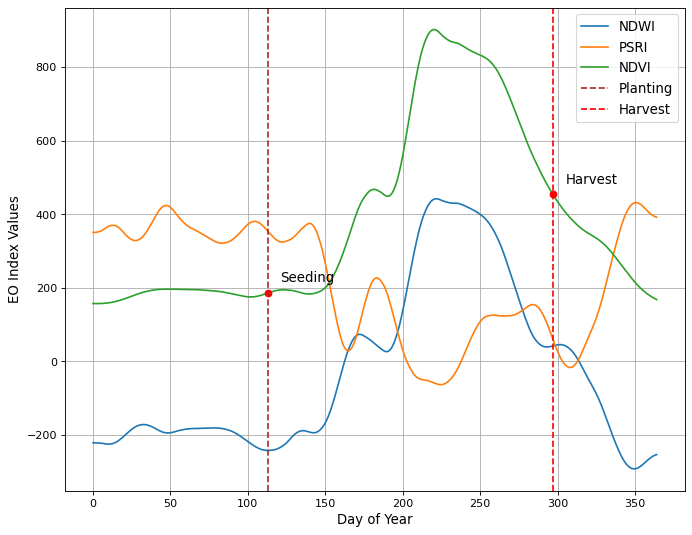

In [41]:
a=ndvi.columns[10]
plt.figure(num=None, figsize=(10,8), dpi=80, facecolor='w', edgecolor='k')
ndwi.loc[:,a].plot(label='NDWI')
psri.loc[:,a].plot(label='PSRI')
ndvi.loc[:,a].plot(label='NDVI')

plt.plot(validation.loc[a,:].seeding, np.array(ndvi.loc[ndvi.index == validation.loc[a,:].seeding,a])[0], marker='o', color='red')
plt.text(validation.loc[a,:].seeding+8,np.array(ndvi.loc[ndvi.index == validation.loc[a,:].seeding,a])[0]+30,'Seeding',fontsize=12)

plt.plot(validation.loc[a,:].harvest, np.array(ndvi.loc[ndvi.index == validation.loc[a,:].harvest,a])[0], marker='o', color='red')
plt.text(validation.loc[a,:].harvest+8,np.array(ndvi.loc[ndvi.index == validation.loc[a,:].harvest,a])[0]+30,'Harvest',fontsize=12)


plt.axvline(validation.loc[a,:].seeding, color='brown', linestyle='--', label='Planting')
plt.axvline(validation.loc[a,:].harvest, color='red', linestyle='--', label='Harvest')
plt.xlabel('Day of Year',fontsize=12)
plt.ylabel('EO Index Values',fontsize=12)
plt.legend(fontsize = 12)
plt.grid()
plt.savefig('indices_validation.png', dpi=100)

In [31]:
l=list()
for i in range(1,ndwi.shape[0]+1):
    l.append('NDWI_DOY%s'%i)
ndwi.index = np.asarray(l)

In [30]:
l=list()
for i in range(1,psri.shape[0]+1):
    l.append('PSRI_DOY%s'%i)
psri.index = np.asarray(l)

In [31]:
data_ndwi_psri = pd.concat([ndwi.T,psri.T],axis=1)
data_ndwi_psri.to_csv('C:/Users/antonkout/Documents/Work/antonkoutpersolnal/data_ndwi_psri.csv')